# **Bibliotecas e Funções**

In [ ]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [ ]:
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste

In [ ]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(302582, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.900006,1.028664,-1.095067,-0.714301,0.958036,1.605010,-1.664088,-0.567847,0.737288,-0.078540,...,0.933829,0.327366,0.896330,-1.117133,0.396181,0.154944,0.964441,-0.475073,Colorretal,0
1,2.017011,0.078323,0.709472,1.270371,-0.915765,-1.584428,0.545300,1.015205,-1.536653,0.848079,...,-1.183185,-0.851058,-1.799187,0.743452,0.599581,-0.940442,-1.048322,-0.514970,Mama,1
2,0.474908,1.091681,-0.572151,1.167751,-0.344597,1.142798,0.315561,-0.242155,-0.156064,-0.038330,...,-1.672914,-0.765173,0.926783,-0.202185,0.393904,-0.406625,-0.776427,-0.218179,Pele,1


In [ ]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(100864, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.366829,-0.972134,1.141405,1.343451,0.958036,-0.047542,0.60093,-0.567847,0.737288,-0.078540,...,-1.734289,1.587885,0.660606,-1.716753,0.396181,1.180668,-1.036870,-0.475073,Colorretal,1
1,-0.166349,-0.972134,-0.649610,1.343451,0.958036,-0.873817,0.60093,1.761039,0.737288,-0.078540,...,-0.209650,1.767959,-0.282288,0.900562,-0.968850,0.154944,-1.036870,-0.475073,Colorretal,1
2,-0.623264,0.078323,-0.758504,1.270371,-0.915765,-1.584428,0.54530,1.015205,-1.536653,0.848079,...,-0.446767,-0.851058,-0.888302,0.743452,-0.803767,0.967430,-1.048322,-0.514970,Mama,1


In [ ]:
df_incid_treino.TOPOGRUP.value_counts()

TOPOGRUP
Mama             78399
Pele             75662
Próstata         62583
Colorretal       42083
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
um = ['Pulmão', 'Colo de Útero']
dois = ['Colo de Útero', 'Mama', 'Pulmão']

df1_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(um)]
df1_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(um)]

df2_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(dois)]
df2_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(dois)]

df1_treino.shape, df1_teste.shape, df2_treino.shape, df2_teste.shape

((43855, 25), (14620, 25), (122254, 25), (40753, 25))

In [ ]:
# DFs de teste para cada tipo
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Mama']
# colo_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colorretal']
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pulmão']
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colo de Útero']

mama_teste.shape, pulm_teste.shape, colo_utero_teste.shape

((26133, 25), (9252, 25), (5368, 25))

In [ ]:
from sklearn.utils import shuffle

df1_treino = shuffle(df1_treino, random_state=seed)
df1_teste = shuffle(df1_teste, random_state=seed)

df2_treino = shuffle(df2_treino, random_state=seed)
df2_teste = shuffle(df2_teste, random_state=seed)

# **Pulmão com Colo do Útero**

In [ ]:
df1_treino.TOPOGRUP.value_counts()

TOPOGRUP
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
# Valores faltantes
df1_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df1_treino.sobrevida_3anos.value_counts()

sobrevida_3anos
0    30947
1    12908
Name: count, dtype: int64

## **Pré-processamento**

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df1_treino['TOPOGRUP'] = oe.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = oe.transform(df1_teste[['TOPOGRUP']])

ss = StandardScaler()
df1_treino['TOPOGRUP'] = ss.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = ss.transform(df1_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df1_treino.drop(columns=list_drop).copy()
y_train = df1_treino.sobrevida_3anos.copy()

# Teste
X_test = df1_teste.drop(columns=list_drop).copy()
y_test = df1_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((43855, 24), (43855,), (14620, 24), (14620,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

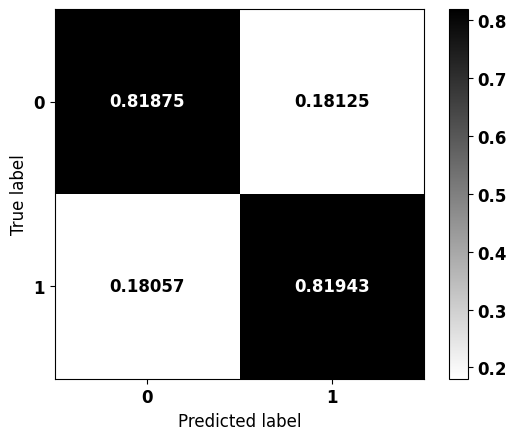


              precision    recall  f1-score   support

           0    0.91576   0.81875   0.86454     10317
           1    0.65345   0.81943   0.72709      4303

    accuracy                        0.81895     14620
   macro avg    0.78461   0.81909   0.79581     14620
weighted avg    0.83856   0.81895   0.82408     14620



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=2.415,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

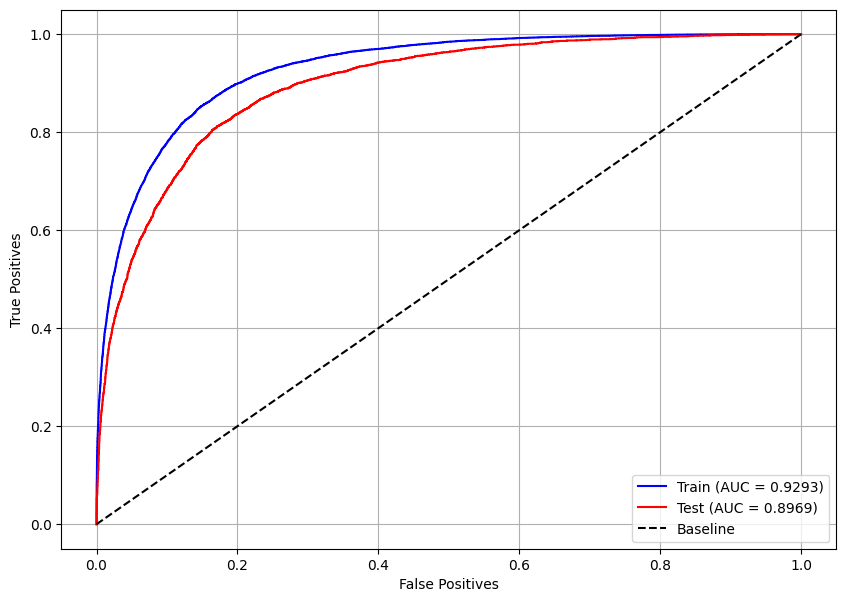

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

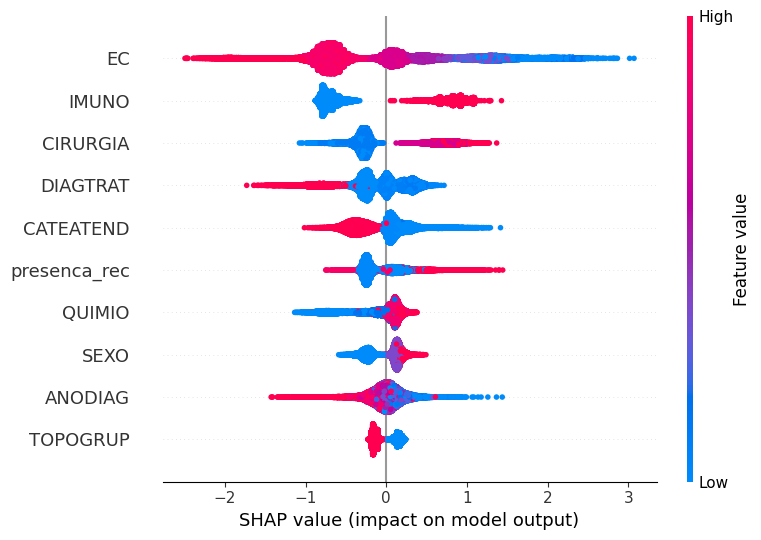

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 105,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.25, 2.29, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

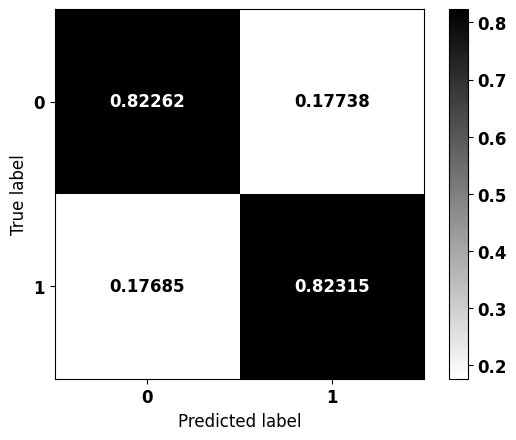


              precision    recall  f1-score   support

           0    0.91771   0.82262   0.86757     10317
           1    0.65934   0.82315   0.73220      4303

    accuracy                        0.82278     14620
   macro avg    0.78853   0.82288   0.79988     14620
weighted avg    0.84167   0.82278   0.82773     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.259

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

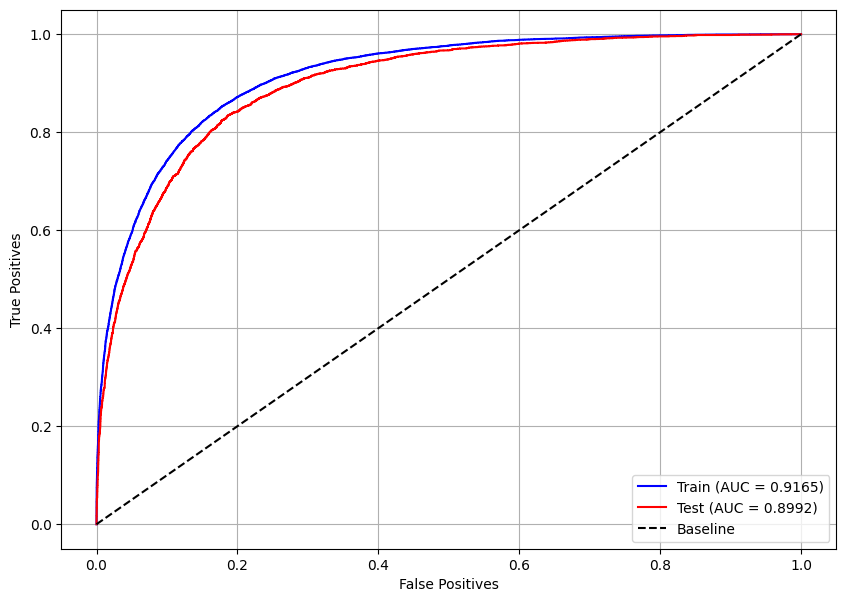

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 111,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(2.25, 2.29, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

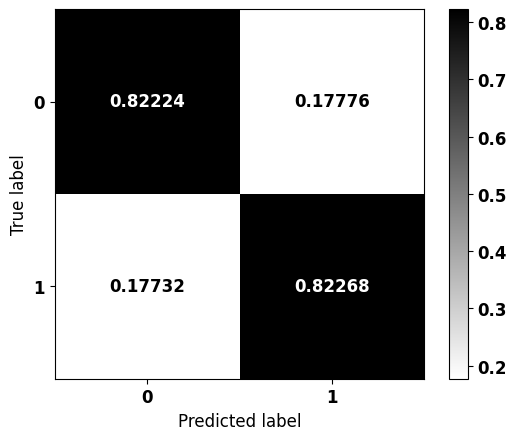


              precision    recall  f1-score   support

           0    0.91748   0.82224   0.86725     10317
           1    0.65873   0.82268   0.73163      4303

    accuracy                        0.82237     14620
   macro avg    0.78810   0.82246   0.79944     14620
weighted avg    0.84132   0.82237   0.82733     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.288

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

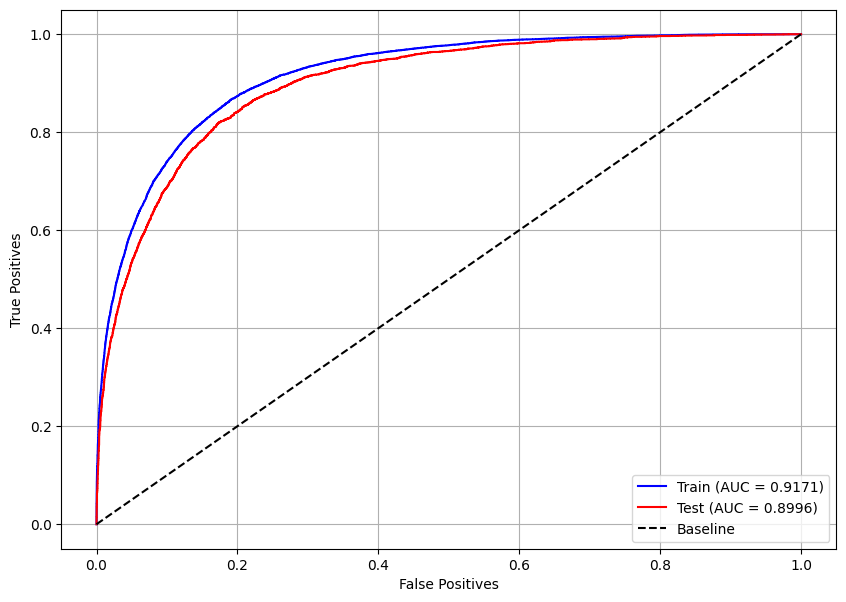

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 143,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(2.25, 2.3, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

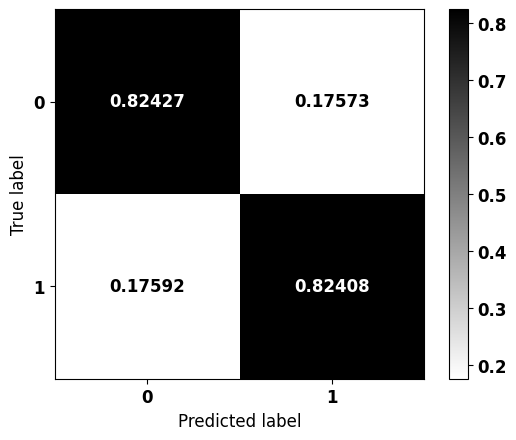


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 2.277

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

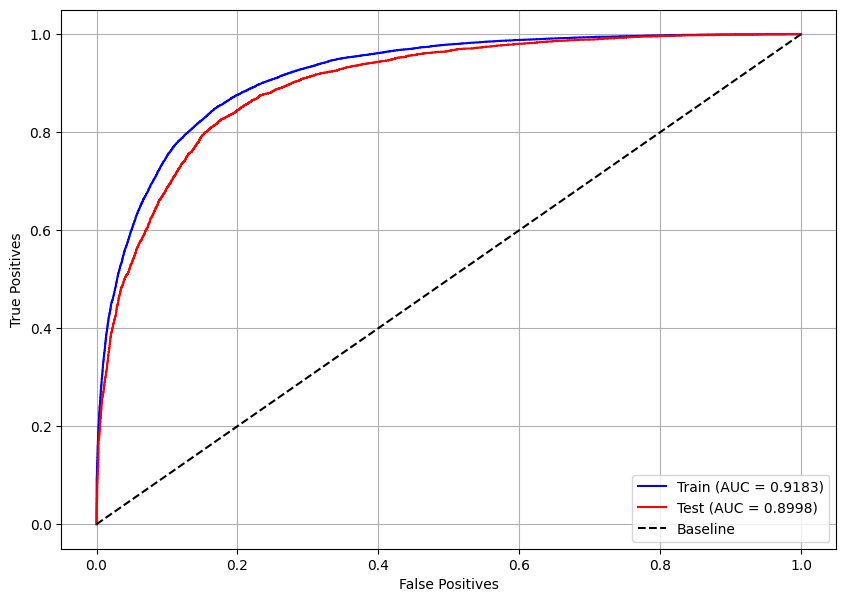

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


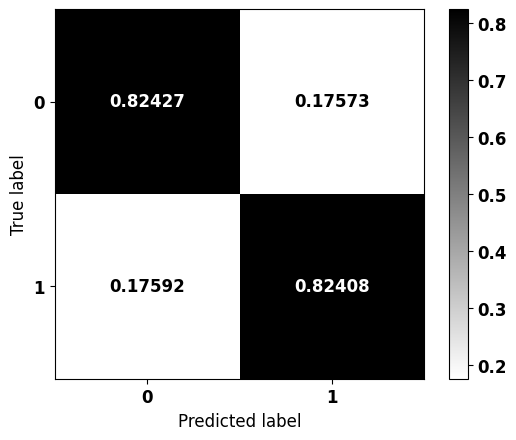


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

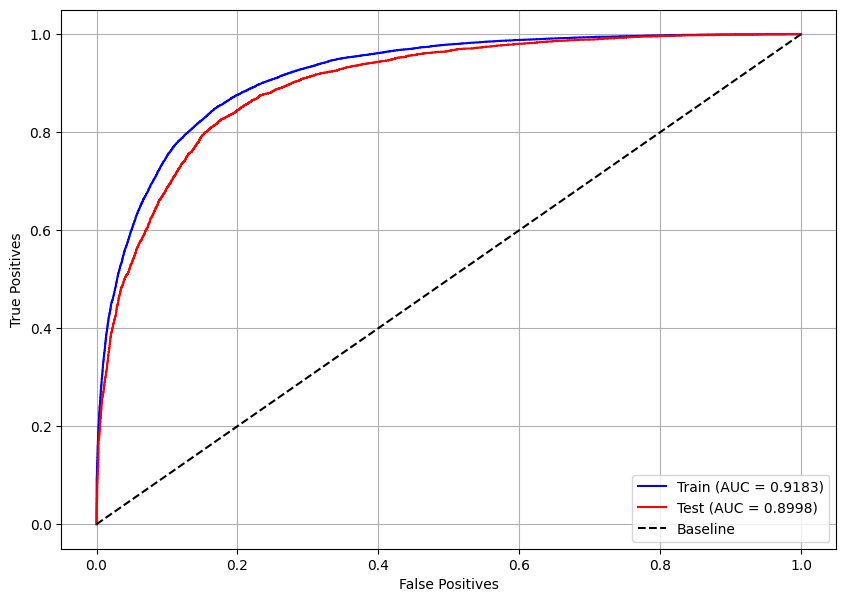

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

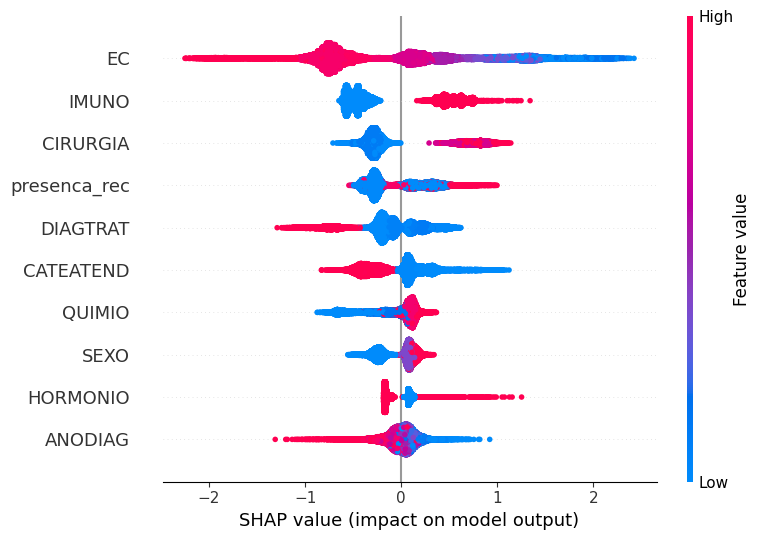

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

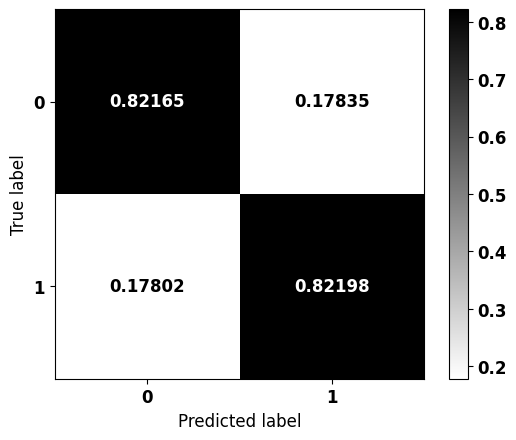


              precision    recall  f1-score   support

           0    0.91713   0.82165   0.86677     10317
           1    0.65780   0.82198   0.73079      4303

    accuracy                        0.82175     14620
   macro avg    0.78746   0.82182   0.79878     14620
weighted avg    0.84080   0.82175   0.82675     14620



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:2.267},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

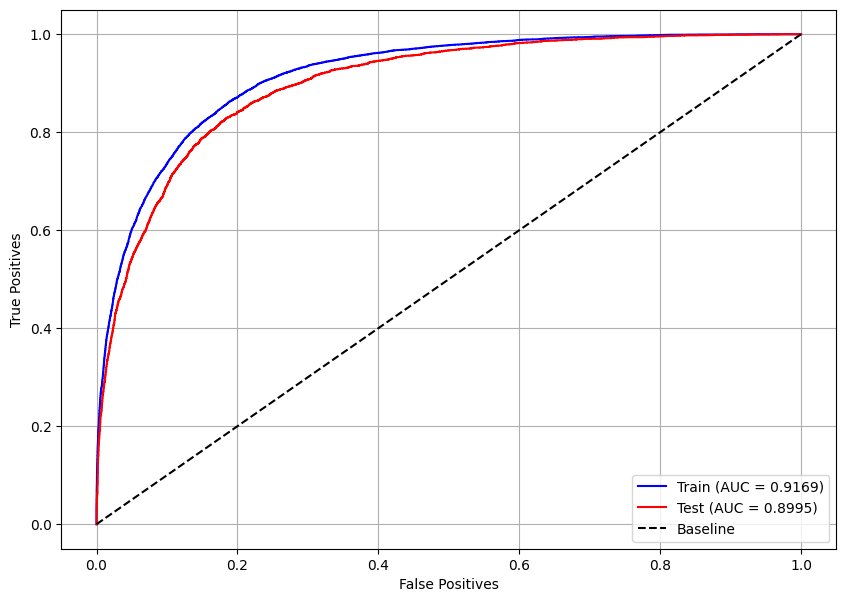

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

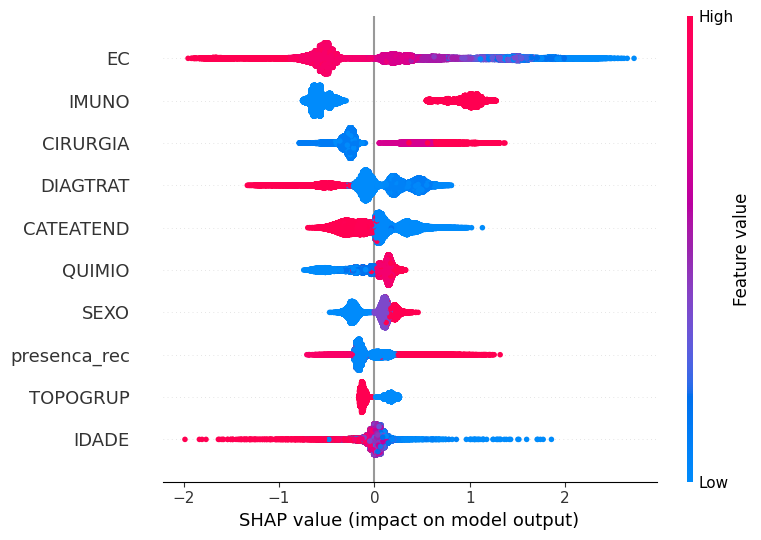

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 102,
 'max_depth': 6,
 'learning_rate': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(2.25, 2.3, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

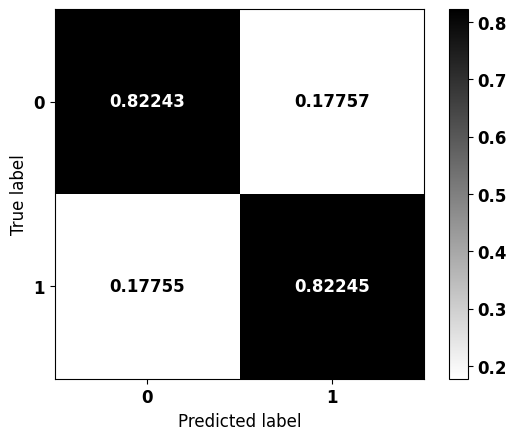


              precision    recall  f1-score   support

           0    0.91740   0.82243   0.86732     10317
           1    0.65891   0.82245   0.73165      4303

    accuracy                        0.82244     14620
   macro avg    0.78815   0.82244   0.79949     14620
weighted avg    0.84132   0.82244   0.82739     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.257}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

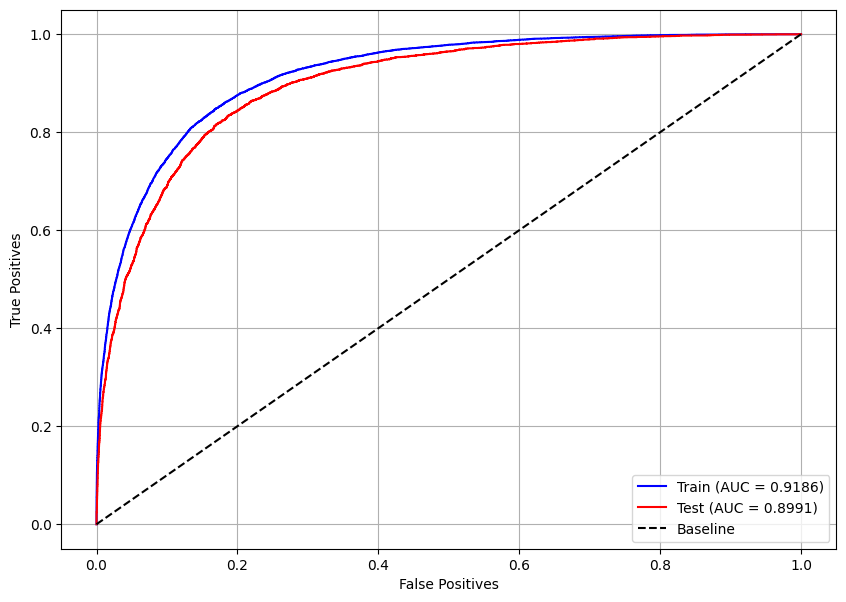

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 139,
 'max_depth': 10,
 'learning_rate': 0.1,
 'min_child_weight': 1,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.3, 2.34, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

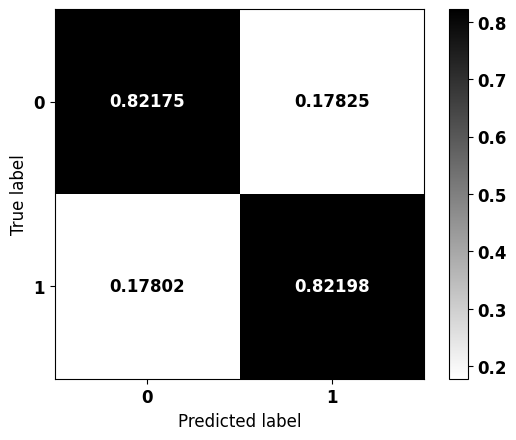


              precision    recall  f1-score   support

           0    0.91714   0.82175   0.86683     10317
           1    0.65792   0.82198   0.73086      4303

    accuracy                        0.82182     14620
   macro avg    0.78753   0.82187   0.79884     14620
weighted avg    0.84084   0.82182   0.82681     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.303}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

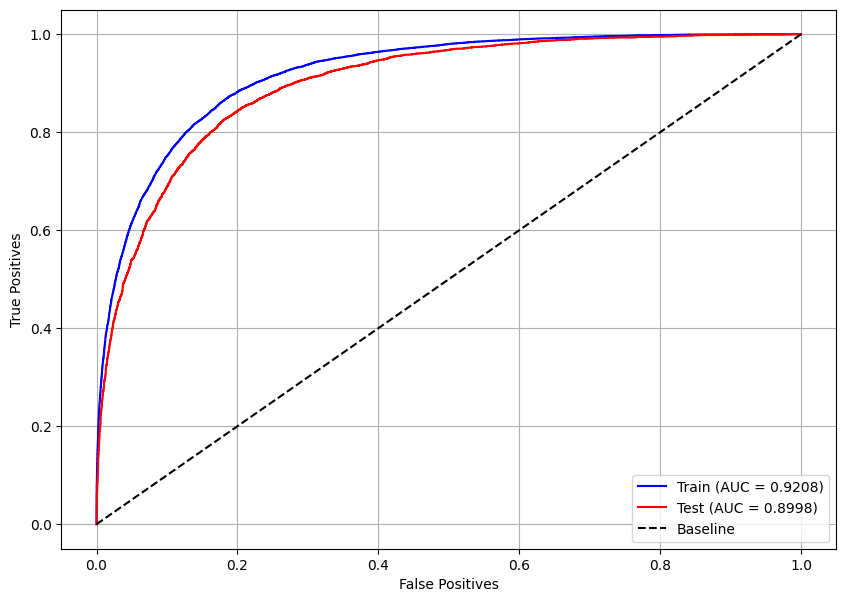

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 104,
 'max_depth': 9,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.24, 2.3, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

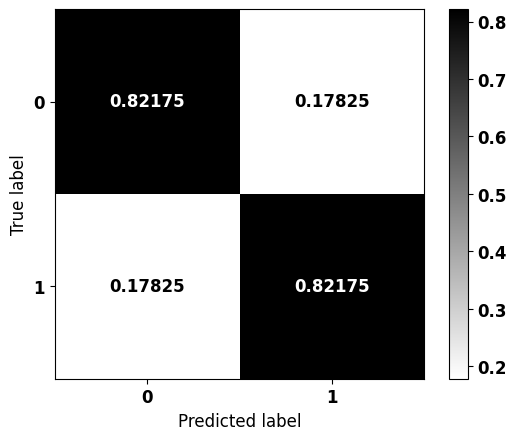


              precision    recall  f1-score   support

           0    0.91704   0.82175   0.86678     10317
           1    0.65786   0.82175   0.73073      4303

    accuracy                        0.82175     14620
   macro avg    0.78745   0.82175   0.79876     14620
weighted avg    0.84075   0.82175   0.82674     14620



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.265}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

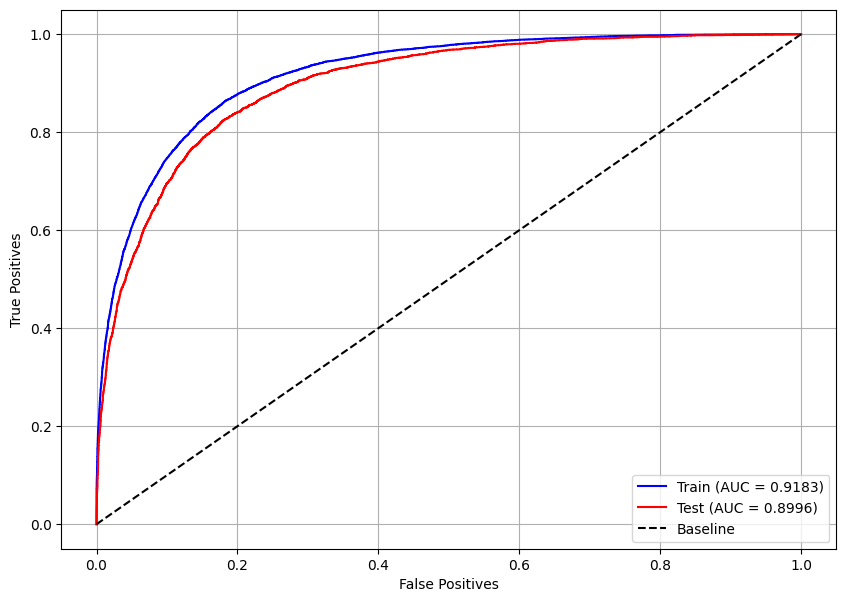

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 2.257}, colsample_bytree=0.3,
               learning_rate=0.2, max_depth=6, min_child_weight=1,
               n_estimators=102, random_state=7, verbose=-1)


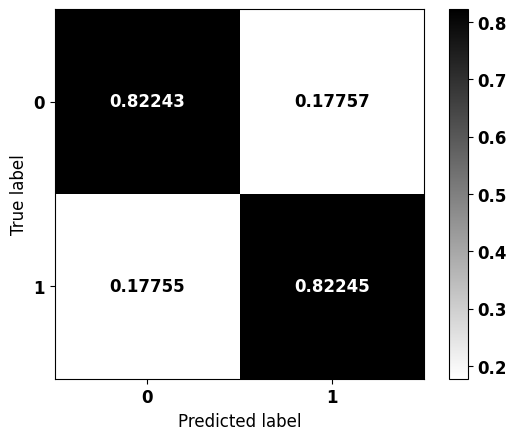


              precision    recall  f1-score   support

           0    0.91740   0.82243   0.86732     10317
           1    0.65891   0.82245   0.73165      4303

    accuracy                        0.82244     14620
   macro avg    0.78815   0.82244   0.79949     14620
weighted avg    0.84132   0.82244   0.82739     14620



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

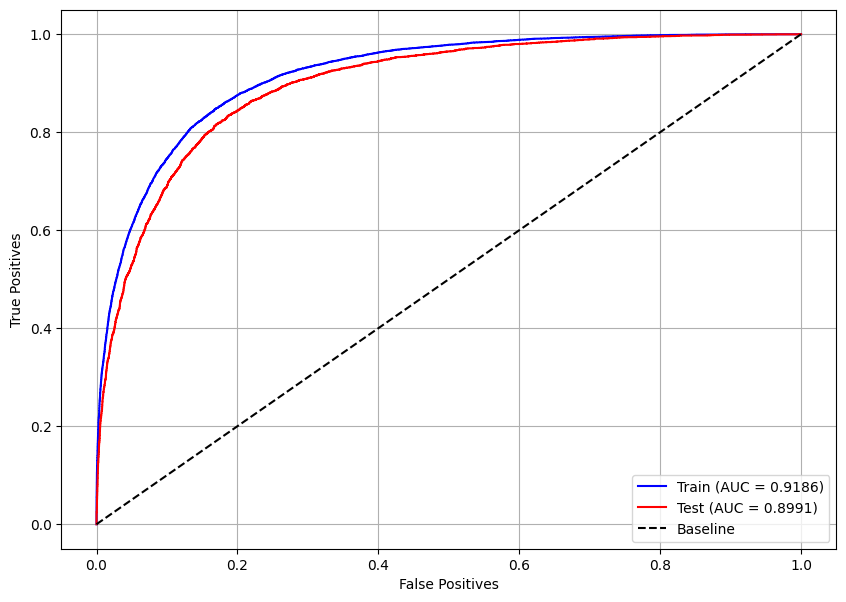

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

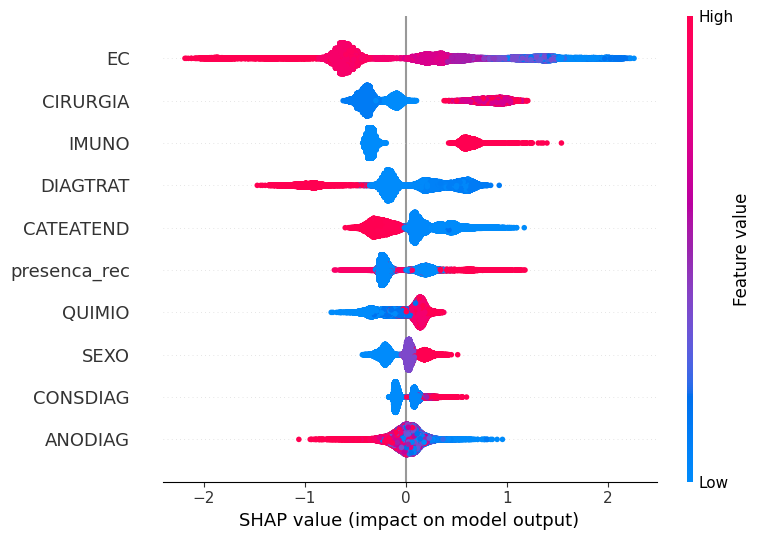

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


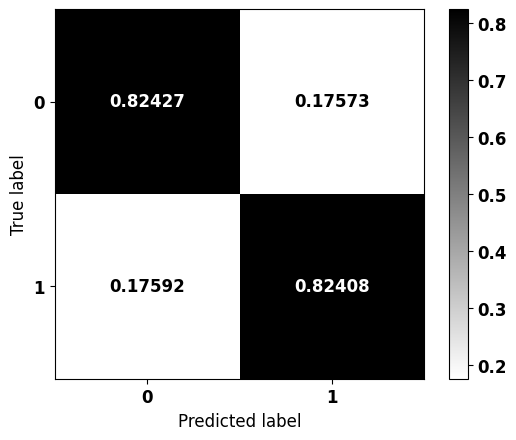


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

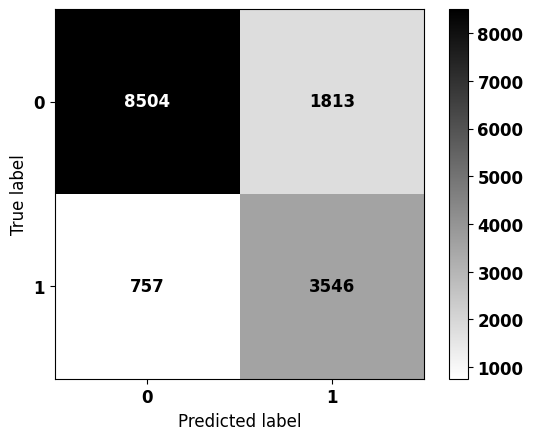


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

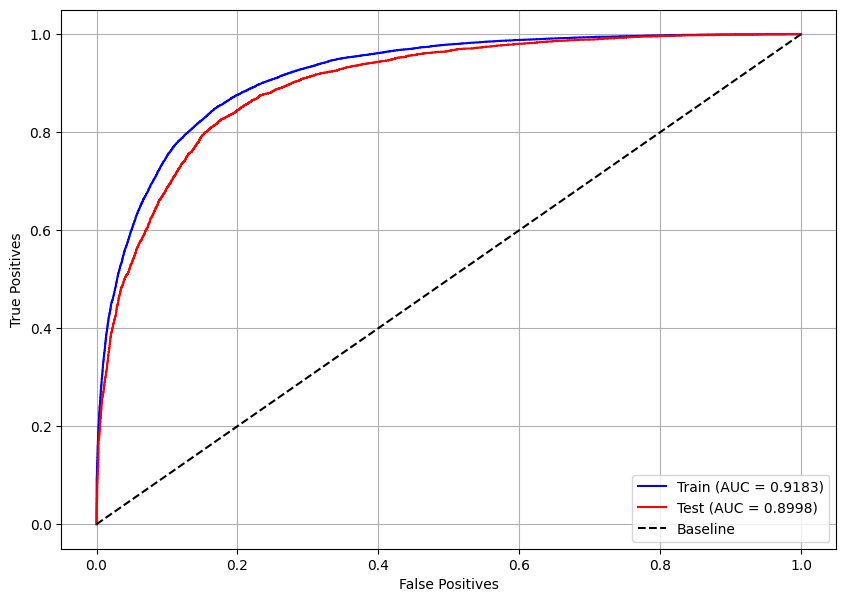

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(best, X_train, X_test, y_train, y_test)

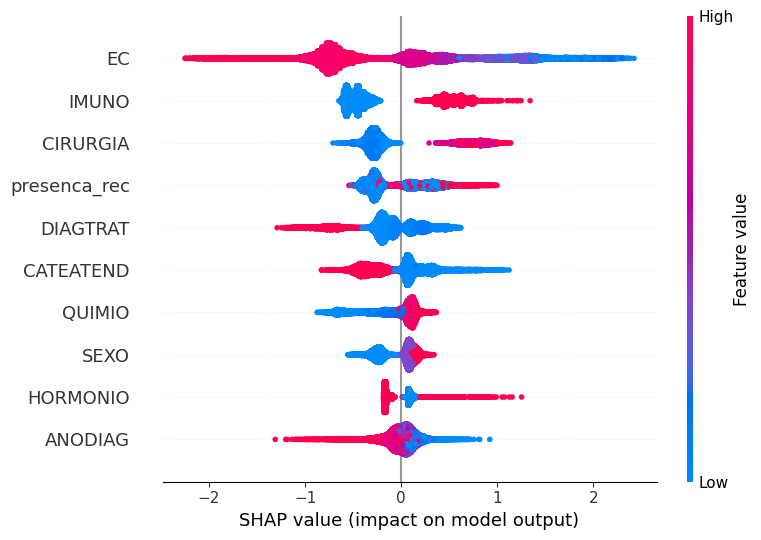

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(best, X_train, feat_cols)

In [ ]:
# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

X_test_pulm['TOPOGRUP'] = oe.transform(X_test_pulm[['TOPOGRUP']])
X_test_pulm['TOPOGRUP'] = ss.transform(X_test_pulm[['TOPOGRUP']])

# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero['TOPOGRUP'] = oe.transform(X_test_colo_utero[['TOPOGRUP']])
X_test_colo_utero['TOPOGRUP'] = ss.transform(X_test_colo_utero[['TOPOGRUP']])

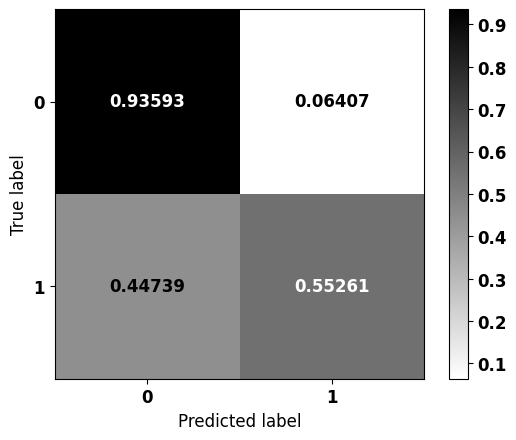


              precision    recall  f1-score   support

           0    0.93082   0.93593   0.93337      8007
           1    0.57286   0.55261   0.56255      1245

    accuracy                        0.88435      9252
   macro avg    0.75184   0.74427   0.74796      9252
weighted avg    0.88265   0.88435   0.88347      9252



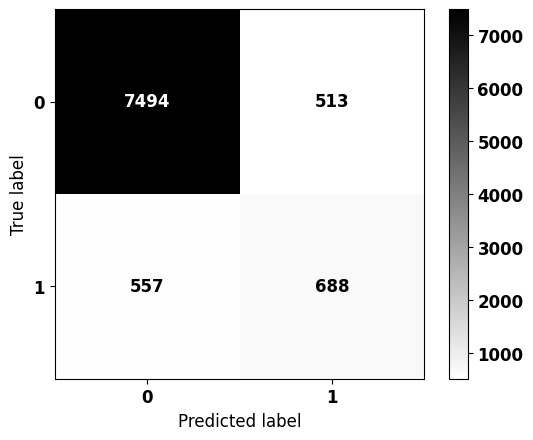


              precision    recall  f1-score   support

           0    0.93082   0.93593   0.93337      8007
           1    0.57286   0.55261   0.56255      1245

    accuracy                        0.88435      9252
   macro avg    0.75184   0.74427   0.74796      9252
weighted avg    0.88265   0.88435   0.88347      9252



In [ ]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

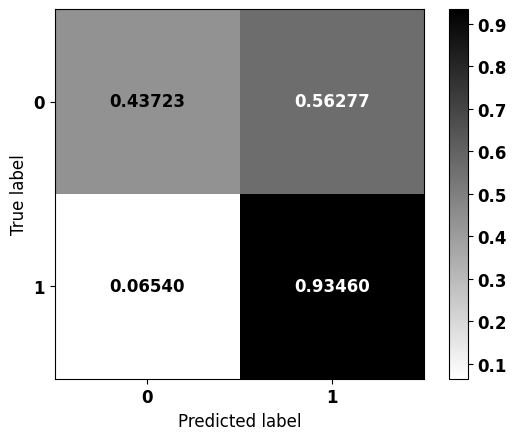


              precision    recall  f1-score   support

           0    0.83471   0.43723   0.57386      2310
           1    0.68735   0.93460   0.79213      3058

    accuracy                        0.72057      5368
   macro avg    0.76103   0.68591   0.68300      5368
weighted avg    0.75076   0.72057   0.69820      5368



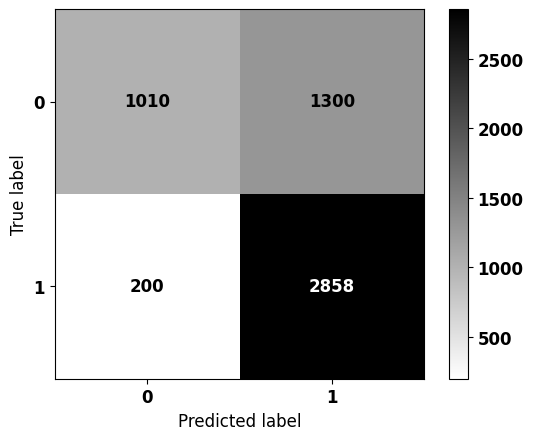


              precision    recall  f1-score   support

           0    0.83471   0.43723   0.57386      2310
           1    0.68735   0.93460   0.79213      3058

    accuracy                        0.72057      5368
   macro avg    0.76103   0.68591   0.68300      5368
weighted avg    0.75076   0.72057   0.69820      5368



In [ ]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.8189, Optuna = 0.8242

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.8218, Optuna = 0.8224

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 2.257}, colsample_bytree=0.3,
               learning_rate=0.2, max_depth=6, min_child_weight=1,
               n_estimators=102, random_state=7, verbose=-1)

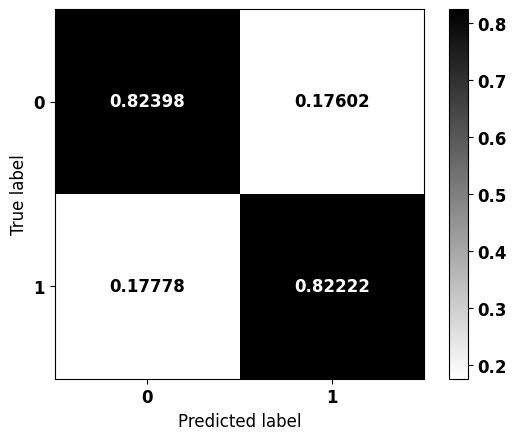


              precision    recall  f1-score   support

           0    0.91744   0.82398   0.86820     10317
           1    0.66081   0.82222   0.73273      4303

    accuracy                        0.82346     14620
   macro avg    0.78913   0.82310   0.80047     14620
weighted avg    0.84191   0.82346   0.82833     14620



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

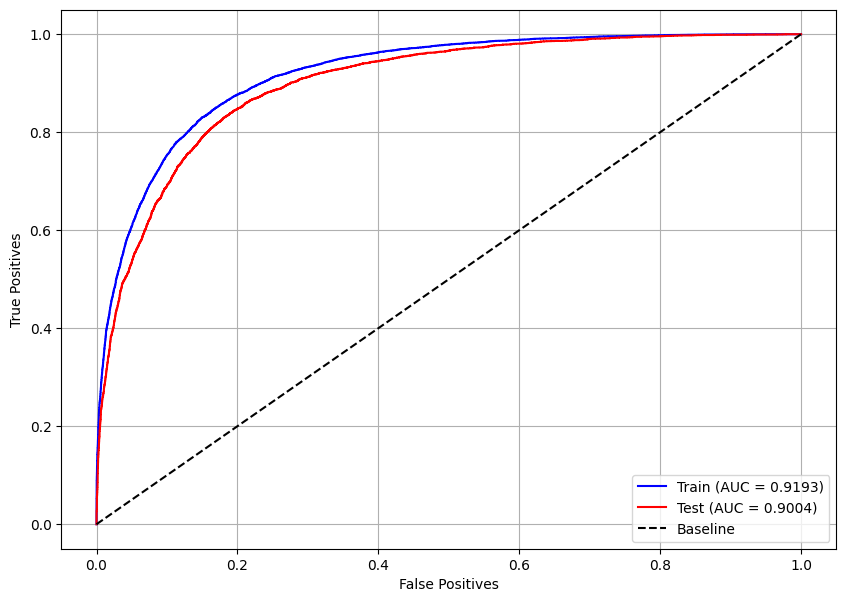

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Colo do Útero com Mama e Pulmão**

In [ ]:
df2_treino.TOPOGRUP.value_counts()

TOPOGRUP
Mama             78399
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
# Valores faltantes
df2_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df2_treino.sobrevida_3anos.value_counts()

sobrevida_3anos
1    75766
0    46488
Name: count, dtype: int64

## **Pré-processamento**

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df2_treino['TOPOGRUP'] = oe.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = oe.transform(df2_teste[['TOPOGRUP']])

ss = StandardScaler()
df2_treino['TOPOGRUP'] = ss.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = ss.transform(df2_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df2_treino.drop(columns=list_drop).copy()
y_train = df2_treino.sobrevida_3anos.copy()

# Teste
X_test = df2_teste.drop(columns=list_drop).copy()
y_test = df2_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((122254, 24), (122254,), (40753, 24), (40753,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

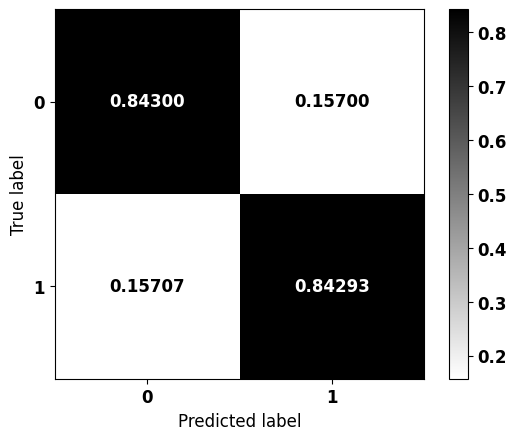


              precision    recall  f1-score   support

           0    0.76707   0.84300   0.80325     15497
           1    0.89744   0.84293   0.86933     25256

    accuracy                        0.84296     40753
   macro avg    0.83225   0.84297   0.83629     40753
weighted avg    0.84786   0.84296   0.84420     40753



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=6,
                    scale_pos_weight=0.566,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

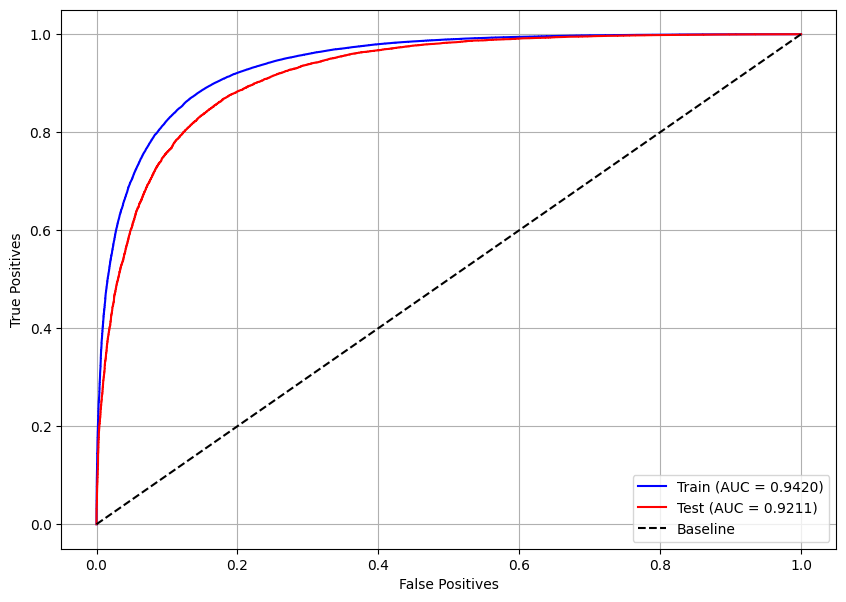

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

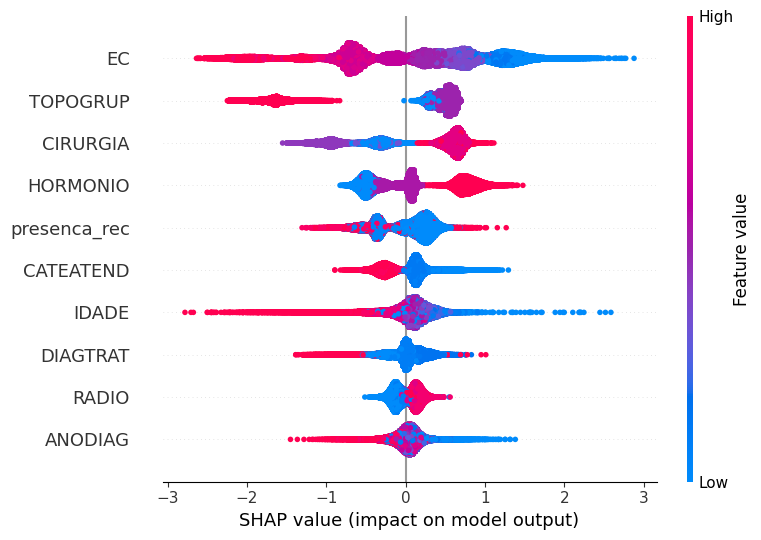

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 141,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

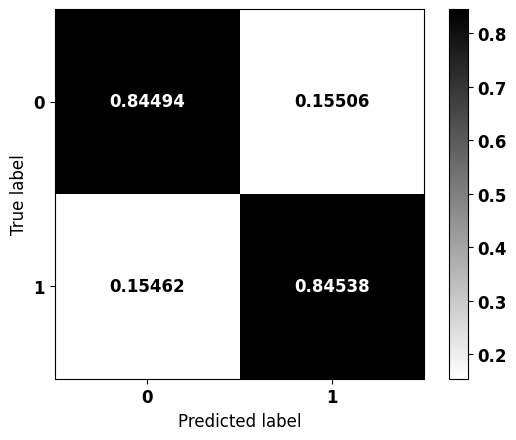


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.572

xgb_rand = XGBClassifier()
xgb_rand.set_params(**params)

xgb_rand.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_rand, X_test, y_test)

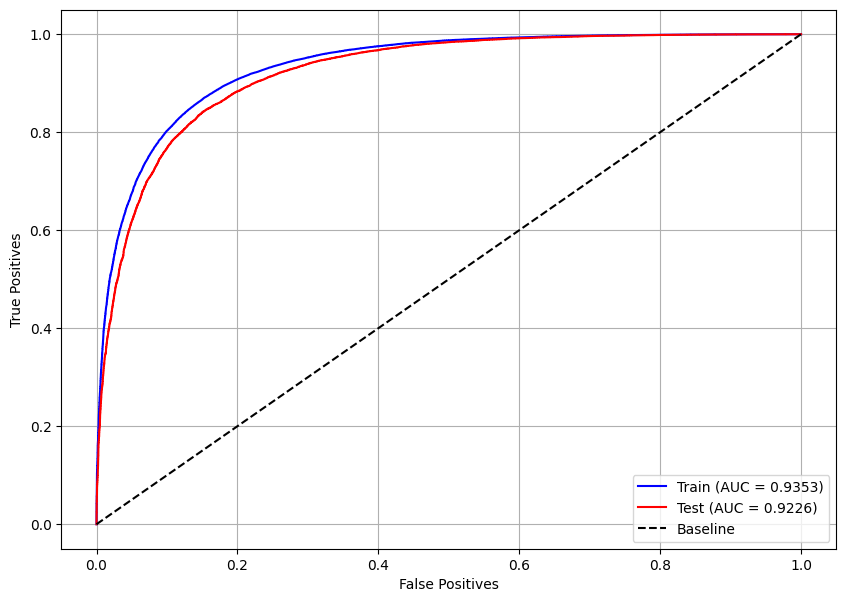

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 127,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

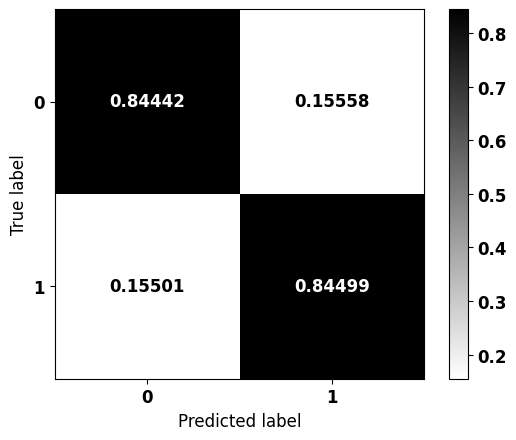


              precision    recall  f1-score   support

           0    0.76972   0.84442   0.80534     15497
           1    0.89849   0.84499   0.87092     25256

    accuracy                        0.84477     40753
   macro avg    0.83411   0.84470   0.83813     40753
weighted avg    0.84952   0.84477   0.84598     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5665

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

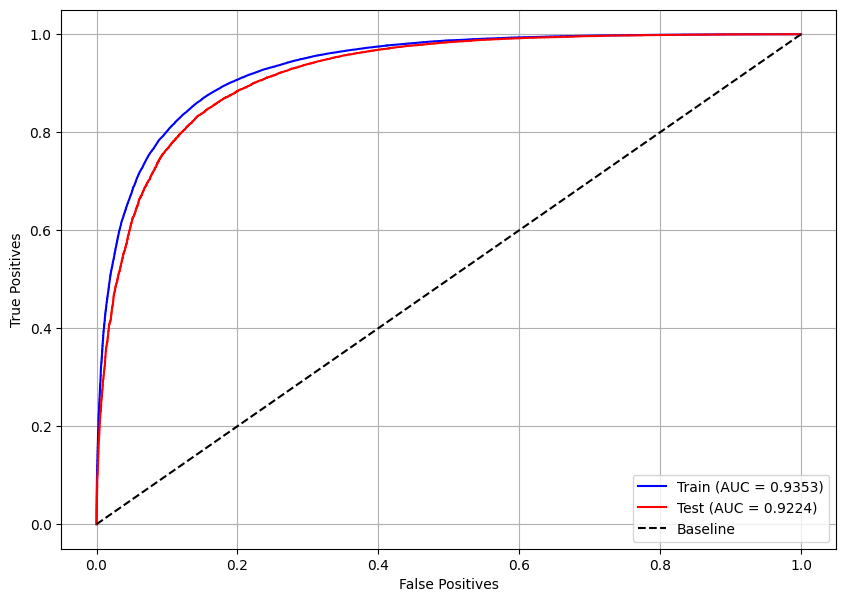

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 134,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.55, 0.575, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

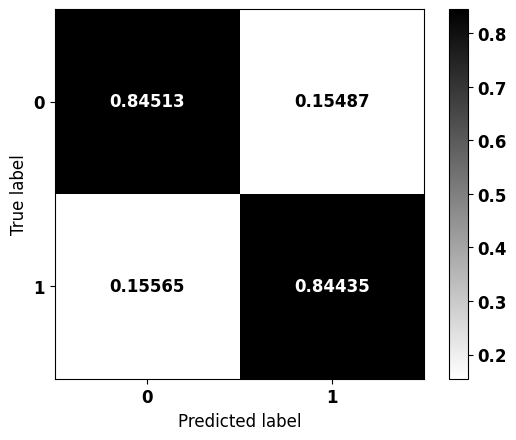


              precision    recall  f1-score   support

           0    0.76914   0.84513   0.80535     15497
           1    0.89884   0.84435   0.87075     25256

    accuracy                        0.84465     40753
   macro avg    0.83399   0.84474   0.83805     40753
weighted avg    0.84952   0.84465   0.84588     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.5661

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

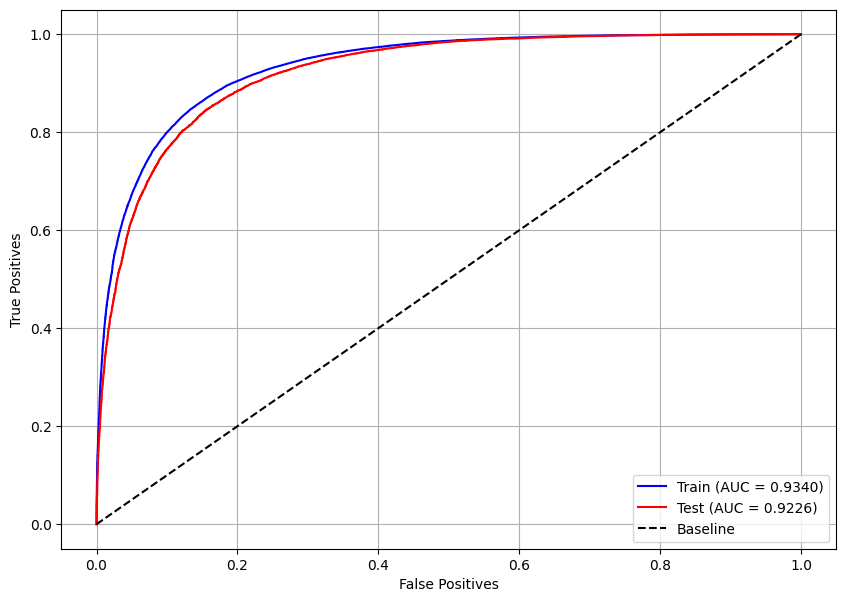

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_rand, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


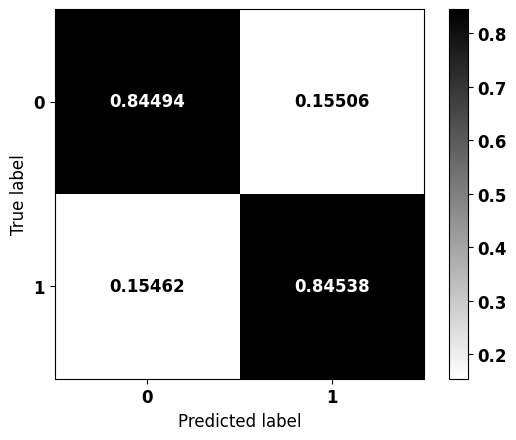


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

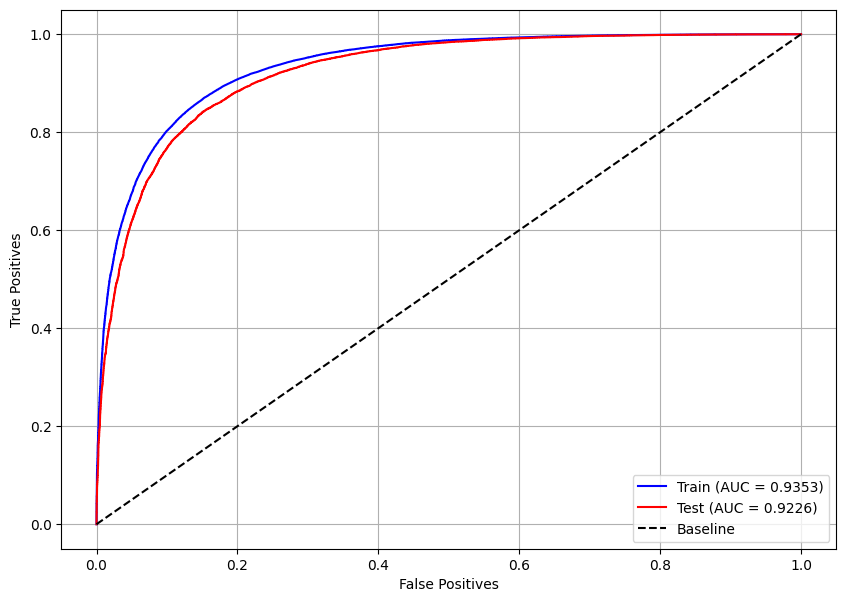

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

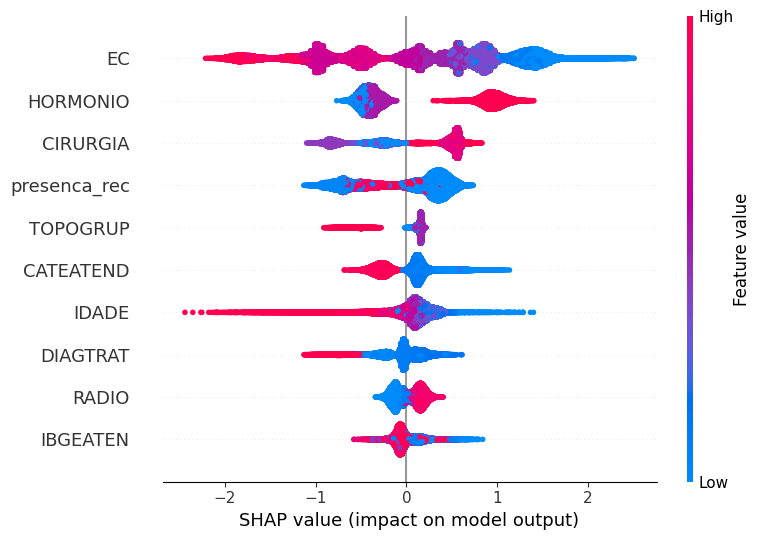

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

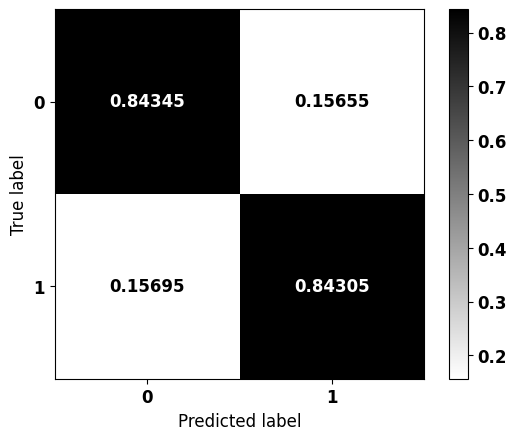


              precision    recall  f1-score   support

           0    0.76730   0.84345   0.80358     15497
           1    0.89771   0.84305   0.86952     25256

    accuracy                        0.84320     40753
   macro avg    0.83251   0.84325   0.83655     40753
weighted avg    0.84812   0.84320   0.84445     40753



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.665, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

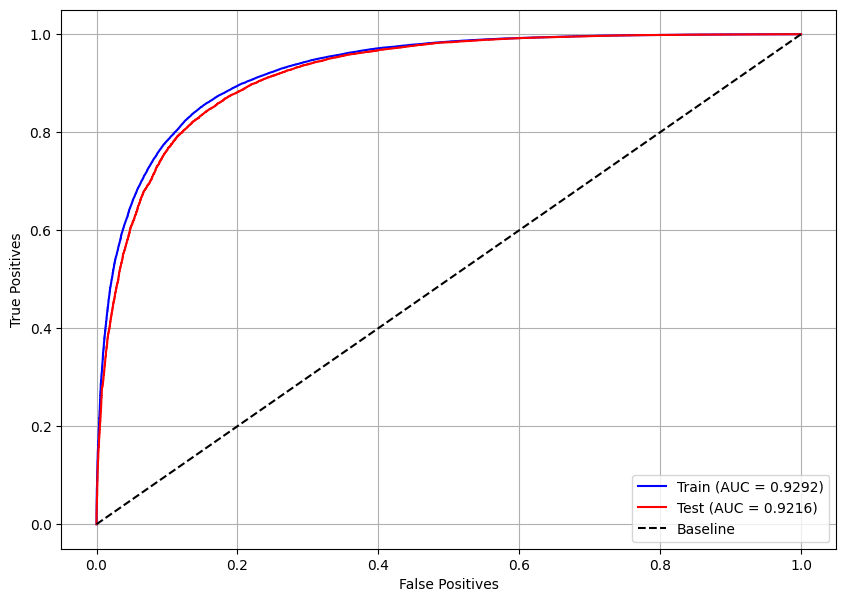

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

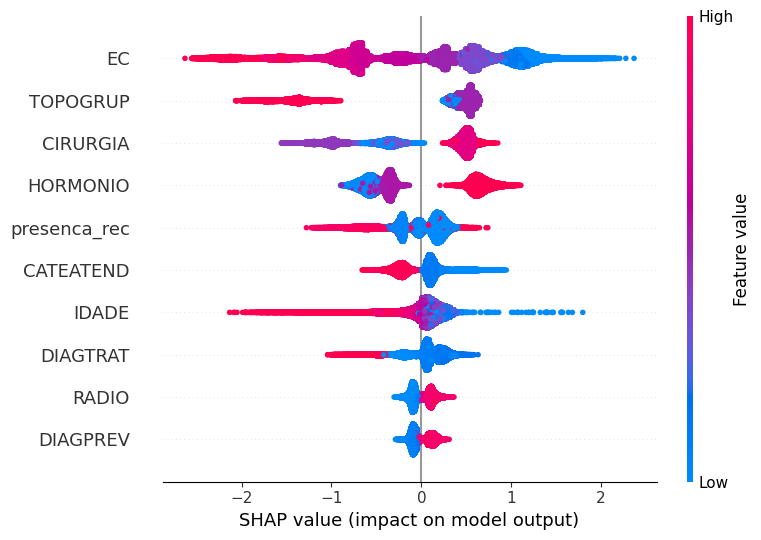

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 8,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 4,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(1.7, 1.74, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

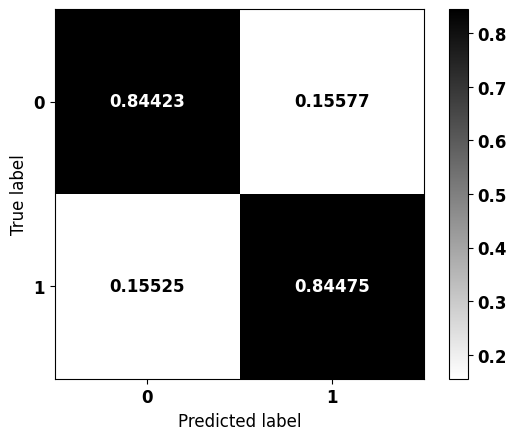


              precision    recall  f1-score   support

           0    0.76941   0.84423   0.80508     15497
           1    0.89835   0.84475   0.87073     25256

    accuracy                        0.84455     40753
   macro avg    0.83388   0.84449   0.83791     40753
weighted avg    0.84932   0.84455   0.84577     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.733, 1:1}

lgbm_rand = LGBMClassifier(verbose=-1)
lgbm_rand.set_params(**params)

lgbm_rand.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_rand, X_test, y_test)

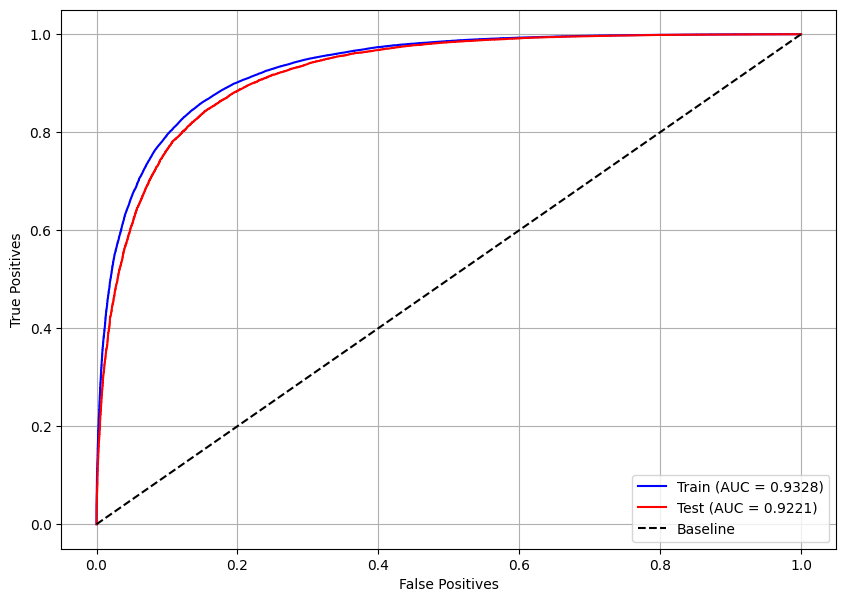

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_rand, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 124,
 'max_depth': 9,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.74, 1.78, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

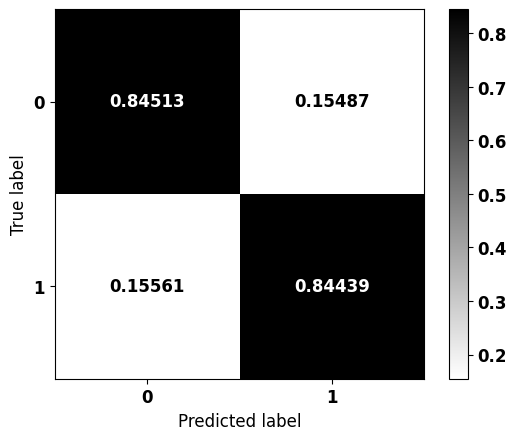


              precision    recall  f1-score   support

           0    0.76919   0.84513   0.80537     15497
           1    0.89885   0.84439   0.87077     25256

    accuracy                        0.84467     40753
   macro avg    0.83402   0.84476   0.83807     40753
weighted avg    0.84954   0.84467   0.84590     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.752, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

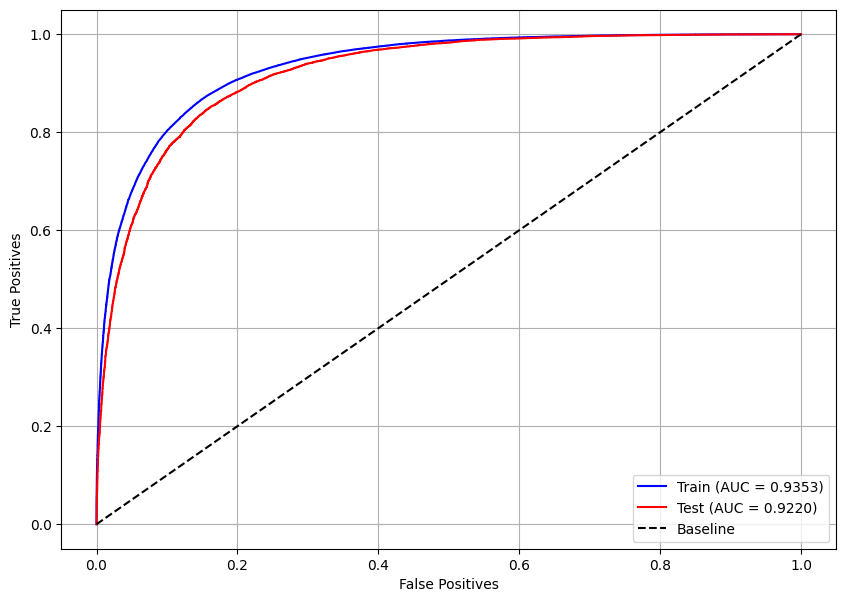

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 135,
 'max_depth': 9,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1.72, 1.76, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

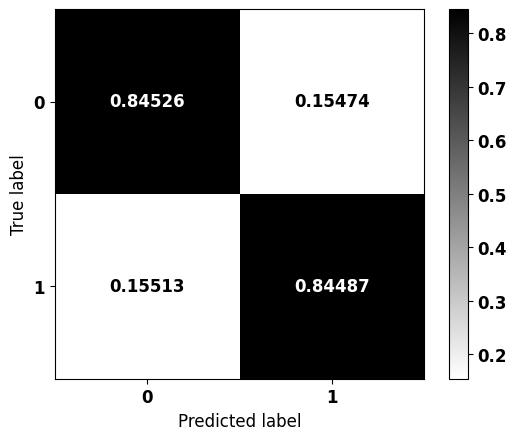


              precision    recall  f1-score   support

           0    0.76976   0.84526   0.80575     15497
           1    0.89897   0.84487   0.87108     25256

    accuracy                        0.84502     40753
   macro avg    0.83437   0.84506   0.83841     40753
weighted avg    0.84984   0.84502   0.84624     40753



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.732, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

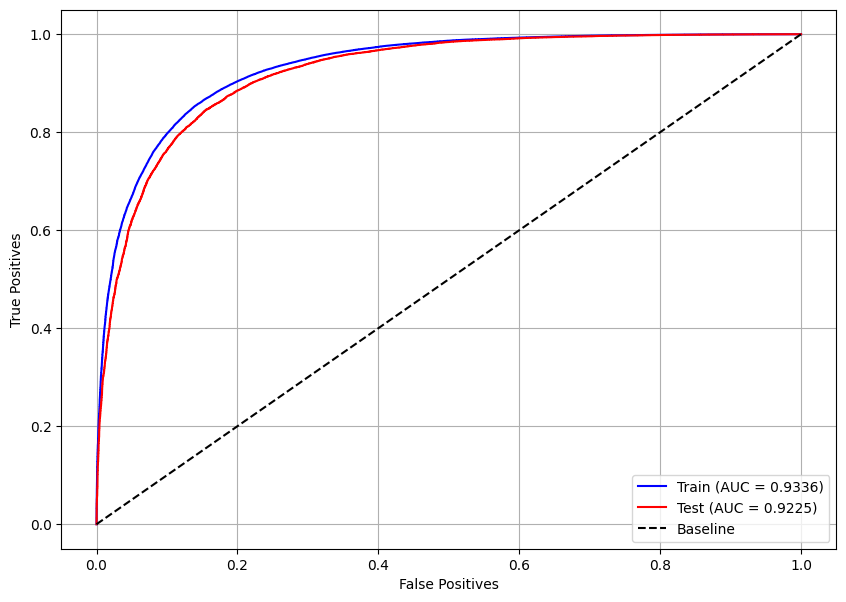

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_rand, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.732, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.15, max_depth=9, min_child_weight=6,
               n_estimators=135, random_state=7, verbose=-1)


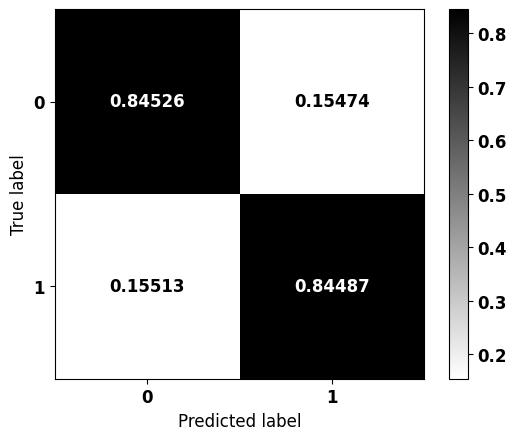


              precision    recall  f1-score   support

           0    0.76976   0.84526   0.80575     15497
           1    0.89897   0.84487   0.87108     25256

    accuracy                        0.84502     40753
   macro avg    0.83437   0.84506   0.83841     40753
weighted avg    0.84984   0.84502   0.84624     40753



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

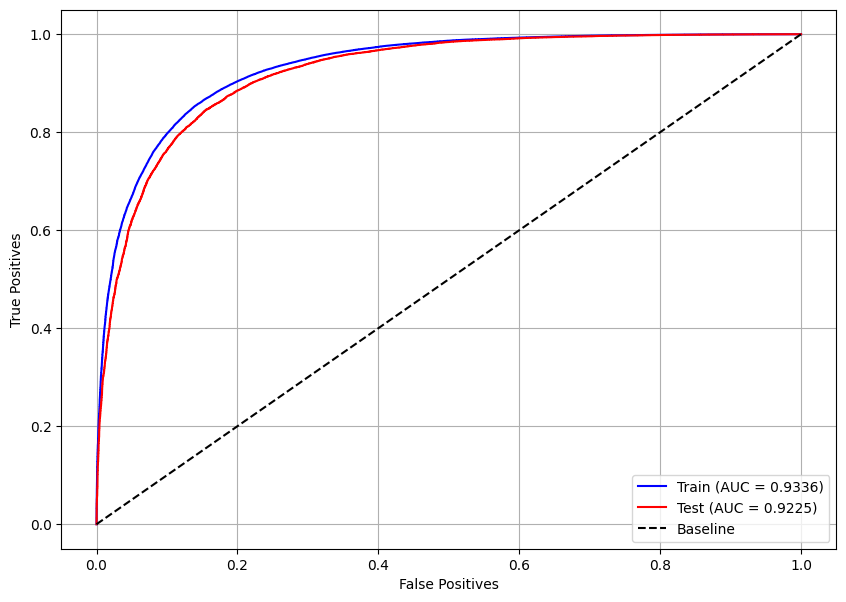

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


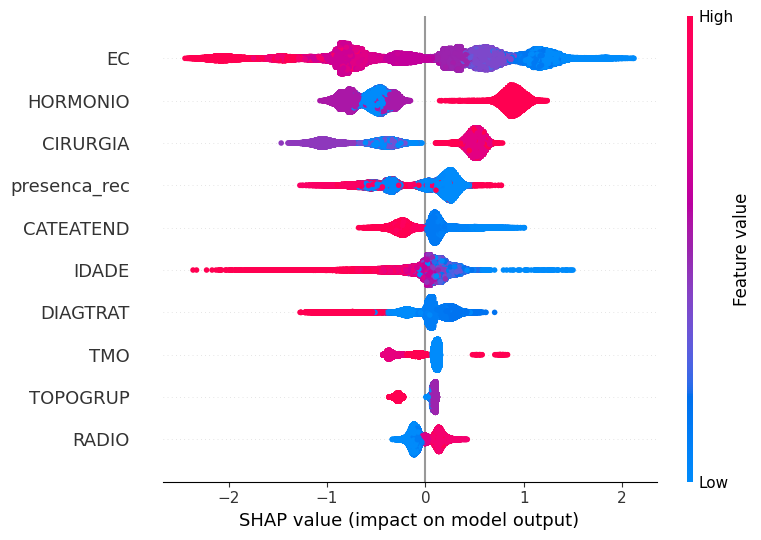

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


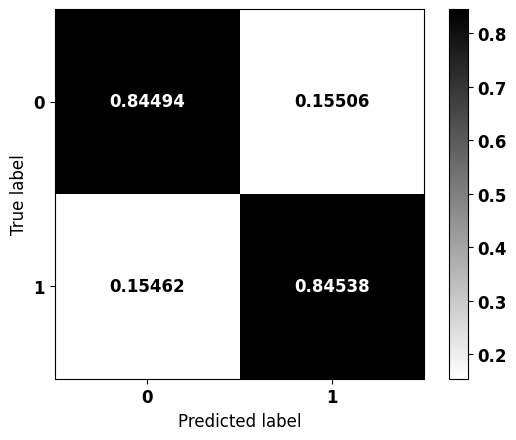


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

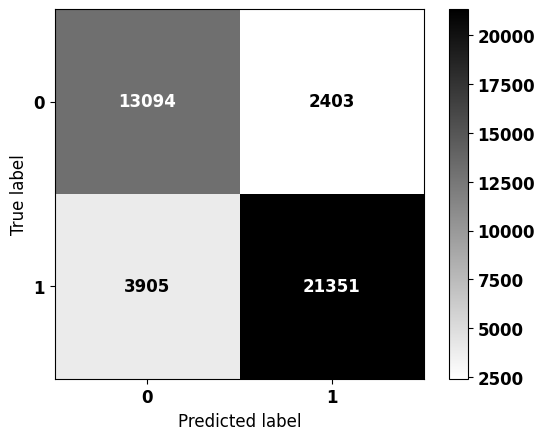


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

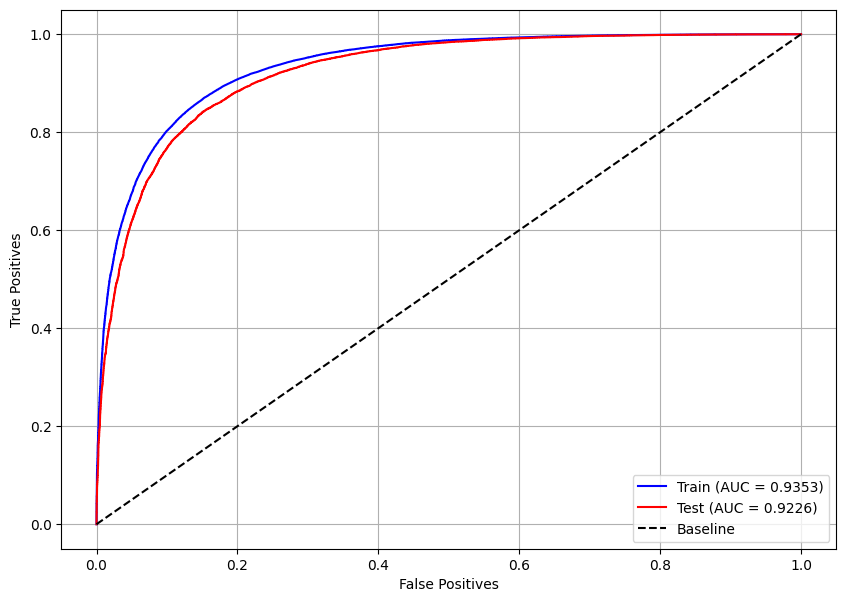

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(best, X_train, X_test, y_train, y_test)

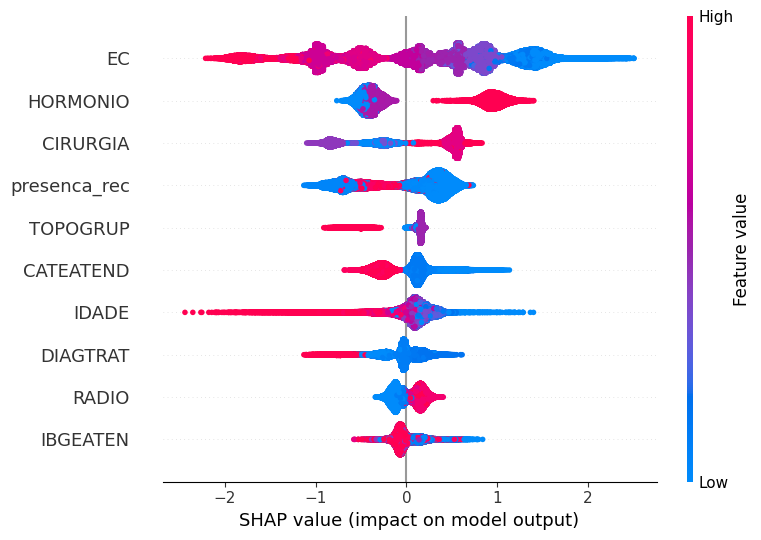

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(best, X_train, feat_cols)

In [ ]:
# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero['TOPOGRUP'] = oe.transform(X_test_colo_utero[['TOPOGRUP']])
X_test_colo_utero['TOPOGRUP'] = ss.transform(X_test_colo_utero[['TOPOGRUP']])

# Mama
X_test_mama = mama_teste.drop(columns=list_drop).copy()
y_test_mama = mama_teste.sobrevida_3anos.copy()

X_test_mama['TOPOGRUP'] = oe.transform(X_test_mama[['TOPOGRUP']])
X_test_mama['TOPOGRUP'] = ss.transform(X_test_mama[['TOPOGRUP']])

# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

X_test_pulm['TOPOGRUP'] = oe.transform(X_test_pulm[['TOPOGRUP']])
X_test_pulm['TOPOGRUP'] = ss.transform(X_test_pulm[['TOPOGRUP']])

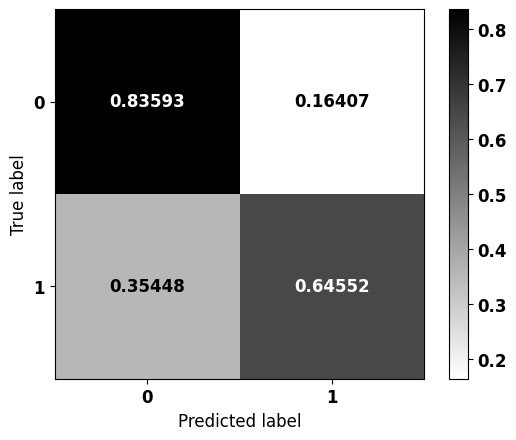


              precision    recall  f1-score   support

           0    0.64046   0.83593   0.72526      2310
           1    0.83893   0.64552   0.72962      3058

    accuracy                        0.72746      5368
   macro avg    0.73970   0.74073   0.72744      5368
weighted avg    0.75352   0.72746   0.72775      5368



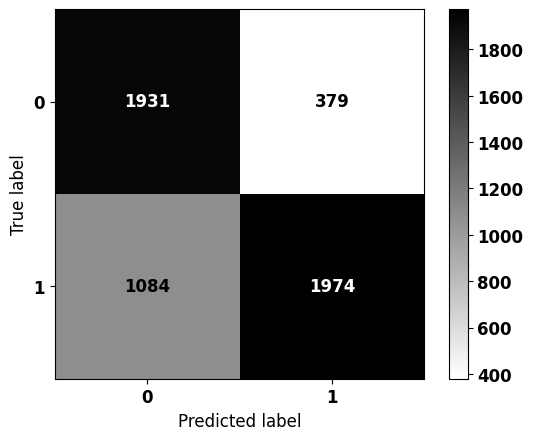


              precision    recall  f1-score   support

           0    0.64046   0.83593   0.72526      2310
           1    0.83893   0.64552   0.72962      3058

    accuracy                        0.72746      5368
   macro avg    0.73970   0.74073   0.72744      5368
weighted avg    0.75352   0.72746   0.72775      5368



In [ ]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

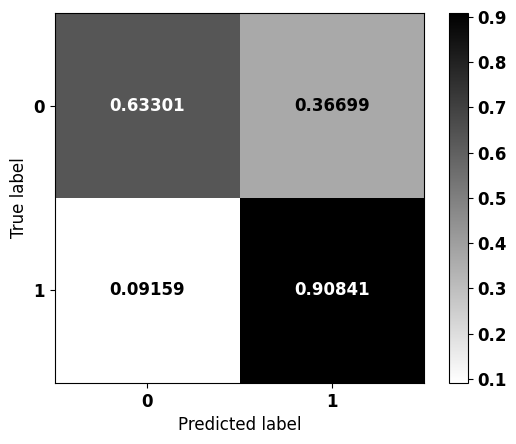


              precision    recall  f1-score   support

           0    0.63082   0.63301   0.63191      5180
           1    0.90920   0.90841   0.90880     20953

    accuracy                        0.85382     26133
   macro avg    0.77001   0.77071   0.77036     26133
weighted avg    0.85402   0.85382   0.85392     26133



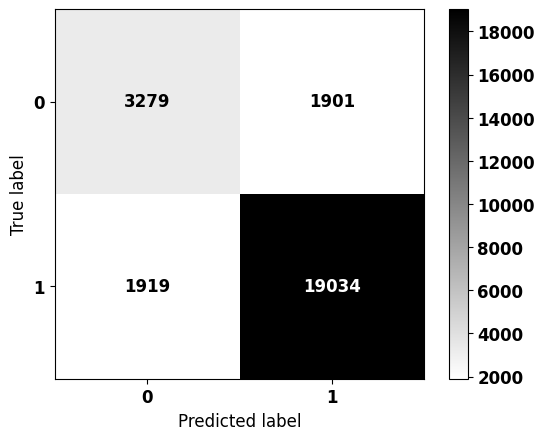


              precision    recall  f1-score   support

           0    0.63082   0.63301   0.63191      5180
           1    0.90920   0.90841   0.90880     20953

    accuracy                        0.85382     26133
   macro avg    0.77001   0.77071   0.77036     26133
weighted avg    0.85402   0.85382   0.85392     26133



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama)
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

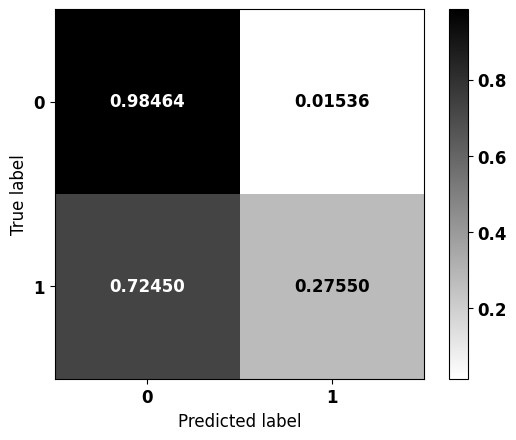


              precision    recall  f1-score   support

           0    0.89734   0.98464   0.93896      8007
           1    0.73605   0.27550   0.40094      1245

    accuracy                        0.88921      9252
   macro avg    0.81669   0.63007   0.66995      9252
weighted avg    0.87563   0.88921   0.86656      9252



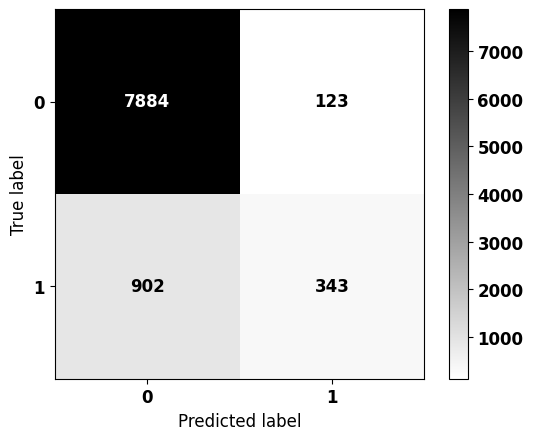


              precision    recall  f1-score   support

           0    0.89734   0.98464   0.93896      8007
           1    0.73605   0.27550   0.40094      1245

    accuracy                        0.88921      9252
   macro avg    0.81669   0.63007   0.66995      9252
weighted avg    0.87563   0.88921   0.86656      9252



In [ ]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.8430, Optuna = 0.8452

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.8432, Optuna = 0.8450

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.732, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.15, max_depth=9, min_child_weight=6,
               n_estimators=135, random_state=7, verbose=-1)

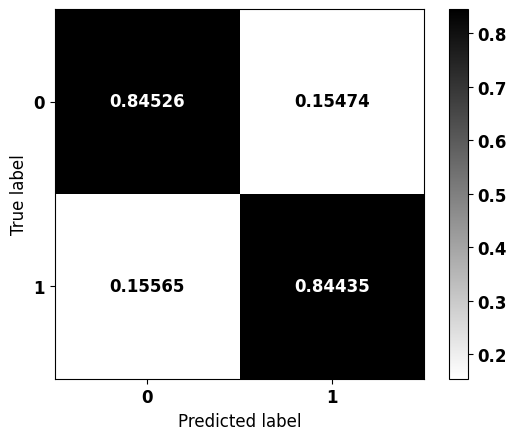


              precision    recall  f1-score   support

           0    0.76917   0.84526   0.80542     15497
           1    0.89892   0.84435   0.87078     25256

    accuracy                        0.84470     40753
   macro avg    0.83404   0.84481   0.83810     40753
weighted avg    0.84958   0.84470   0.84593     40753



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

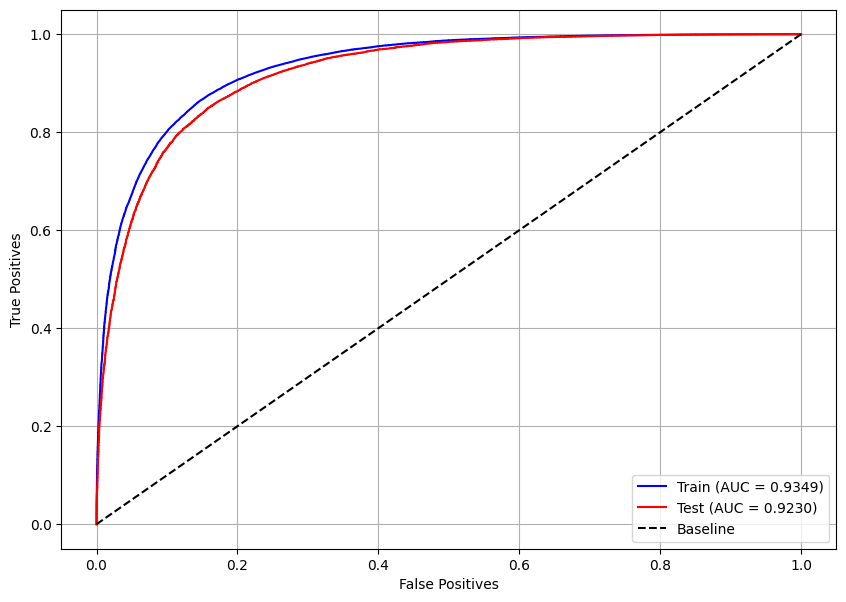

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)